# Lending Club Investment Project

Build a model that will help select the best loans to invest in

The note book is divided into 3 main sections



*   Import data
*   EDA
*   Building a model





In [808]:
# import packages

import numpy as np
import pandas as pd
import random
import sklearn
import datetime
import scipy
import math
import itertools


import seaborn as sns
import matplotlib.pyplot as plt

from os import replace

from sklearn.model_selection import (
    StratifiedKFold, KFold, train_test_split,
    cross_val_score, GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_curve, roc_auc_score, make_scorer
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [809]:
# import data

# 2016 data
df_1 = pd.read_csv("/content/2016Q1.csv.gz")
df_2 = pd.read_csv("/content/2016Q2.csv.gz")
df_3 = pd.read_csv("/content/2016Q3.csv.gz")
df_4 = pd.read_csv("/content/2016Q4.csv.gz")

# 2017 data
df_5 = pd.read_csv("/content/2017Q1.csv.gz")
df_6 = pd.read_csv("/content/2017Q2.csv.gz")
df_7 = pd.read_csv("/content/2017Q3.csv.gz")
df_8 = pd.read_csv("/content/2017Q4.csv.gz")

# data dictionary
df_data_dictionary = pd.read_excel("/content/data_dictionary.xlsx")
# convert to dictionary format
data_dictionary = df_data_dictionary.set_index('Field').T.to_dict('list')

**Aggregate data sets**

In [810]:
# generate df of potential laons to invest in

# 20% of 2017 Q4 funds will used as potential investment loans
sample_count = round(df_8.shape[0]*.50)

# generate df_invest index
random.seed(10)
invest_index = random.sample(range(0, df_8.shape[0]), sample_count)

# generate df with investment loans
df_invest = df_8.copy()
df_invest = df_invest.iloc[invest_index,:]
df_invest.reset_index(drop=True, inplace=True)

# amend 2017 Q4 df to exclude investment loans
df_8_mod = df_8.copy()
# df_8_mod = df_8_mod[~df_8_mod.index.isin(invest_index)]

# concatenate all non investment loan data
df_total = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], axis=0)
df_total.reset_index(drop=True, inplace=True)

**Functions**

In [811]:
# convert data column to 4-digit year
def date_convert(str_):

  year = str_[-2:]
  month = str_[:-2]

  if int(year) < 18:
    return month+"20"+year
  else:
    return month+"19"+year

# check percentage of nans for each row
def check_nans(df):
  nan_count = df.isna().sum()
  nan_var_list = nan_count[nan_count>0].index.to_list()

  print('% of Nans - excluded zero columns')
  nan_count_percent = (nan_count/df_total.shape[0])*100
  print(nan_count_percent[nan_count_percent!=0])

  return nan_count_percent

# check if nans are consistent accross 3 columns
def cross_nan_check(a, b, c):

  if (math.isnan(a)) & (math.isnan(b)) & (math.isnan(c)):
    return np.nan
  else:
    cleaned_lst = [x for x in [a,b,c] if (math.isnan(x) == False)]

    return min(cleaned_lst)

# function for calculating VIF
def calc_vif(df):

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

# EDA

In [812]:
# df size
print('df number of rows:', df_total.shape[0])
print('df number of columns:', df_total.shape[1])

# check for duplicated loans
duplicates = sum(df_total['id'].duplicated())
if duplicates == 0:
  print("no duplicate id records")
else:
  print("# of duplicate id records = {}".format(duplicates))

df number of rows: 438991
df number of columns: 55
no duplicate id records


In [813]:
# check number of Nans

nan_count_percent = check_nans(df_total)

% of Nans - excluded zero columns
emp_title                          6.917454
emp_length                         6.836814
dti                                0.064922
mths_since_last_delinq            48.674346
revol_util                         0.081778
annual_inc_joint                  94.120836
dti_joint                         94.121064
open_act_il                        0.006150
open_il_24m                        0.006150
il_util                           13.568615
open_rv_24m                        0.006150
all_util                           0.016857
inq_last_12m                       0.006150
bc_open_to_buy                     1.182484
bc_util                            1.227588
mths_since_recent_bc               1.116652
mths_since_recent_bc_dlq          75.620457
mths_since_recent_revol_delinq    65.055092
percent_bc_gt_75                   1.188407
revol_bal_joint                   95.519270
sec_app_fico_range_high           95.519043
sec_app_earliest_cr_line          95.51904

In [814]:
# lets check if creating one new variable can decrease the number of nans
# for mths_since_last_delinq

df_total['deling_new_value'] = df_total.apply(
    lambda x: cross_nan_check(
        x['mths_since_recent_revol_delinq'],
        x['mths_since_recent_bc_dlq'],
        x['mths_since_last_delinq']
        ),
    axis=1
)

# the new variable only has .05% less nans -- i.e. unsuccessful
check_nans(df_total)

# remove new variable
df_total.drop('deling_new_value', axis=1, inplace=True)

% of Nans - excluded zero columns
emp_title                          6.917454
emp_length                         6.836814
dti                                0.064922
mths_since_last_delinq            48.674346
revol_util                         0.081778
annual_inc_joint                  94.120836
dti_joint                         94.121064
open_act_il                        0.006150
open_il_24m                        0.006150
il_util                           13.568615
open_rv_24m                        0.006150
all_util                           0.016857
inq_last_12m                       0.006150
bc_open_to_buy                     1.182484
bc_util                            1.227588
mths_since_recent_bc               1.116652
mths_since_recent_bc_dlq          75.620457
mths_since_recent_revol_delinq    65.055092
percent_bc_gt_75                   1.188407
revol_bal_joint                   95.519270
sec_app_fico_range_high           95.519043
sec_app_earliest_cr_line          95.51904

In [815]:
# features to impute
impute_features = [
    nan_count_percent.index[x] for x in range(len(nan_count_percent)) if
     (nan_count_percent[x] > 0) & (nan_count_percent[x] < 95)
]

# remove features with signficant nan values (would check to understand why nan, first)
drop_columns = [nan_count_percent.index[x] for x in range(len(nan_count_percent)) if nan_count_percent[x] > 50]
df_total.drop(labels=drop_columns, axis=1, inplace=True)

In [816]:
# data types

# list of continoues features
cont_features = [
    df_total.dtypes.index[x] for x in range(len(df_total.dtypes)) if
      (df_total.dtypes[x] == 'int64') or (df_total.dtypes[x] == 'float64')
]

# remove id
cont_features.remove('id')

# list of categorical features
cat_features = [df_total.dtypes.index[x] for x in range(len(df_total.dtypes)) if df_total.dtypes[x] == 'object']

# take a look at categorical variables to understand and transformations that need to be done
df_total.loc[:, cat_features].head(5)

,term,int_rate,emp_title,emp_length,home_ownership,loan_status,purpose,zip_code,addr_state,earliest_cr_line,revol_util,application_type
0,36 months,11.99%,Fraud analyst,8 years,RENT,Fully Paid,debt_consolidation,853xx,AZ,Jul-12,6.90%,Individual
1,36 months,11.47%,Client Relations Manager,< 1 year,RENT,Current,debt_consolidation,972xx,OR,Mar-04,90.10%,Individual
2,36 months,16.29%,Registerd nurse,8 years,MORTGAGE,Current,debt_consolidation,349xx,FL,May-05,49.10%,Individual
3,60 months,12.99%,Financial Advisor,5 years,MORTGAGE,Current,debt_consolidation,601xx,IL,Aug-88,78.10%,Individual
4,60 months,15.31%,Pharmacist-in-Charge,3 years,MORTGAGE,Current,debt_consolidation,373xx,TN,Aug-98,96%,Individual


In [817]:
# investigate number of employment type values
print("number of unique eployment types: ", len(pd.unique(df_total['emp_title'])))

# impossible to turn empl_title to ordinal variable and creating dummy variable per
# each employment title will lead to the curse of dimensionality

# drop emp_title
df_total.drop(labels='emp_title', axis=1, inplace=True)

# remove emp_title from cat_features list
cat_features.remove('emp_title')

# zip codes probably do give some relating to indicating low to high income areas but since we have
# income as a variable no need to keep this as it would explode the number of features and the same with state

# drop zip code and state
df_total.drop(labels=['zip_code', 'addr_state'], axis=1, inplace=True)

# remove zip & state from cat_features list
cat_features.remove('zip_code')
cat_features.remove('addr_state')

number of unique eployment types:  120033


In [818]:
# earlist_cr_line indicate the date they opened their first line of credit, we need to convvert
# to how many months. Essentially there may be a correlation with someone who had their first line
# of credit 20 years ago being more likely to payoff thier loan

# convert year from two digits to four
df_total['earliest_cr_line'] = df_total.earliest_cr_line.apply(date_convert)

# convert date to pandas datetime
df_total['earliest_cr_line'] = pd.to_datetime(df_total['earliest_cr_line'], format='%b-%Y')

# create column for subracting months
df_total['date'] = datetime.datetime(2016, 1, 1)

# find difference between 2016/01/01 and convert to number of months
df_total['earliest_cr_line'] = ((df_total.date - df_total.earliest_cr_line)/np.timedelta64(1, 'M'))
df_total['earliest_cr_line'] = df_total['earliest_cr_line'].astype(int)

# drop unnecessary column
df_total.drop('date', inplace=True, axis=1)

In [819]:
# convert percentages into decimals

convert_lst = ['int_rate', 'revol_util']
for i in convert_lst:
  df_total.loc[:, i] = df_total.loc[:, i].str.replace('%','')
  df_total.loc[:, i] = df_total.loc[:, i].astype(float)
  df_total.loc[:, i] = df_total.loc[:, i].div(100)

# remove features from categorical list that are now continuous
# append to cont. features
remove_cat = ['int_rate','earliest_cr_line','revol_util']
for i in remove_cat:
  cont_features.append(i)

for i in remove_cat:
  cat_features.remove(i)

<ipython-input-819-c686c940c782>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_total.loc[:, i] = df_total.loc[:, i].astype(float)


In [820]:
# understand target variable -- loan_status

df_total['loan_status'].value_counts()/df_total.shape[0]*100

# roughly 40% of data we have definite answer if the loan will be paid in full or not (indicator of good/bad investment)

# current status accounts for about half the data -- this tells us nothing as we do not know what stage the loan is..
# i.e. how many installments are left. If we have this data point per each loan we could potential use loans with
# the status current. Since we do not, they will be removed from the df. Also, loans with the 31-120 days late will
# be rolled into chareged off. Laslty, grace period and 16-30 days late will be removed as well since they make up
# a small percentage of data and the uncertainity if this indicates the loan will be paid.

Current               57.302314
Fully Paid            30.081482
Charged Off            9.317275
Late (31-120 days)     1.869970
In Grace Period        0.914825
Late (16-30 days)      0.514134
Name: loan_status, dtype: float64

In [821]:
# remove rows
remove_values = ['Current', 'In Grace Period', 'Late (16-30 days)']
df_total = df_total[~df_total.loan_status.isin(remove_values)]

# convert late 31-120 days as being charged off
df_total.loc[df_total['loan_status'] == 'Late (31-120 days)', 'loan_status'] = 'Charged Off'

# data set is still imbalanced, which is normal. No one would invest in loans if it was 50/50
# that it be paid off and we are inerested it knowing the probablity of the loan be paid
df_total.loan_status.value_counts()

Fully Paid     132055
Charged Off     49111
Name: loan_status, dtype: int64

In [822]:
df_total.loan_status.value_counts()

Fully Paid     132055
Charged Off     49111
Name: loan_status, dtype: int64

**Correlation**

In [823]:
# turn loan_status into binary feature (1 = loan has been paid in full, 0 = loan has not been paid in full)
loan_status_dict = {
    'Fully Paid': 1,
    'Charged Off': 0,
}

# map to df
#df_total.replace({"loan_status": loan_status_dict}, inplace=True)
df_total['loan_status'] = df_total['loan_status'].replace(loan_status_dict)

<ipython-input-823-729bd8c1461e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['loan_status'] = df_total['loan_status'].replace(loan_status_dict)


In [824]:
# create a table showing relationship with each continuous features relationship with loan_status

cont_corr_dict={}
for i in cont_features:

  corr_df = df_total[[i, 'loan_status']].dropna()
  k,v = scipy.stats.pearsonr(corr_df[i], corr_df['loan_status'])
  cont_corr_dict[i] = [k, v]

corr_df = pd.DataFrame.from_dict(cont_corr_dict, orient='index', columns = ['Corr_coef', 'P-value'])
corr_df.sort_values(by=['Corr_coef'])

,Corr_coef,P-value
int_rate,-0.265433,0.000000e+00
bc_util,-0.106108,0.000000e+00
all_util,-0.101526,0.000000e+00
percent_bc_gt_75,-0.101473,0.000000e+00
revol_util,-0.101042,0.000000e+00
num_rev_tl_bal_gt_0,-0.091224,0.000000e+00
dti,-0.085301,1.536326e-289
open_rv_24m,-0.079333,1.041533e-250
installment,-0.077747,7.369395e-241
inq_last_6mths,-0.074358,1.928646e-220


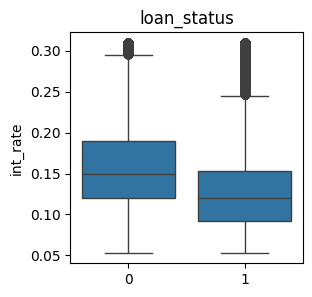

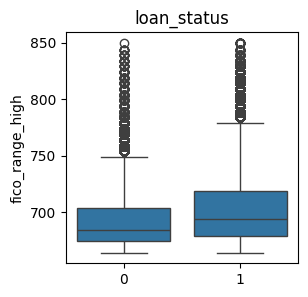

In [825]:


plt.figure(figsize=(3, 3))
sns.boxplot(data=df_total, x='loan_status', y='int_rate').set(title='loan_status',xlabel='')
plt.show()

plt.figure(figsize=(3, 3))
sns.boxplot(data=df_total, x='loan_status', y='fico_range_high').set(title='loan_status',xlabel='')
plt.show()

# we can see the difference of distributions for the features with the highest postive and negative effect on loan_status

In [826]:
# remove features with low correlation between -.015 & .015
low_corr_feat = corr_df.loc[(corr_df['Corr_coef']>-.02) & (corr_df['Corr_coef']<0.02)].index
df_total.drop(low_corr_feat, axis=1, inplace=True)
for i in low_corr_feat:
  cont_features.remove(i)

In [827]:
# it appears many of the variables are correlated with eachother (and a quick galance at the data dictionary
# they seem to being capture relatively the same info). In order to keep the model simple
# and remove repetitive signals, we will remove any highly correlated variables (multicollinearity)

# the feature mths_since_last_delinq - had very minimal correlation with loan status and ~47% nan
# so the it will be dropped. If it was one of the highest correlated variables and no other
# vars could have be used as a proxy then we could have tried to predict the nans via random forest imputation

df_total.drop('mths_since_last_delinq', axis=1, inplace=True)
cont_features.remove('mths_since_last_delinq')


In [828]:
df_vif = df_total[cont_features].copy()

df = calc_vif(df_vif.dropna())

#df_vif.drop('il_util', inplace=True, axis=1)

# filter for features with high VIF
matrix_lst = df[df['VIF']>15]['variables'].to_list()

# view VIF rates
df.sort_values(by=['VIF'], ascending=False, inplace=True)
df

,variables,VIF
5,fico_range_high,172.980710
21,pct_tl_nvr_dlq,154.204487
14,acc_open_past_24mths,147.263051
10,open_rv_24m,64.738197
11,all_util,46.206724
0,funded_amnt,42.859830
1,installment,41.527323
16,bc_util,33.230167
26,revol_util,28.094877
8,open_il_24m,27.015444


In [829]:

df_vif.drop('il_util', inplace=True, axis=1)

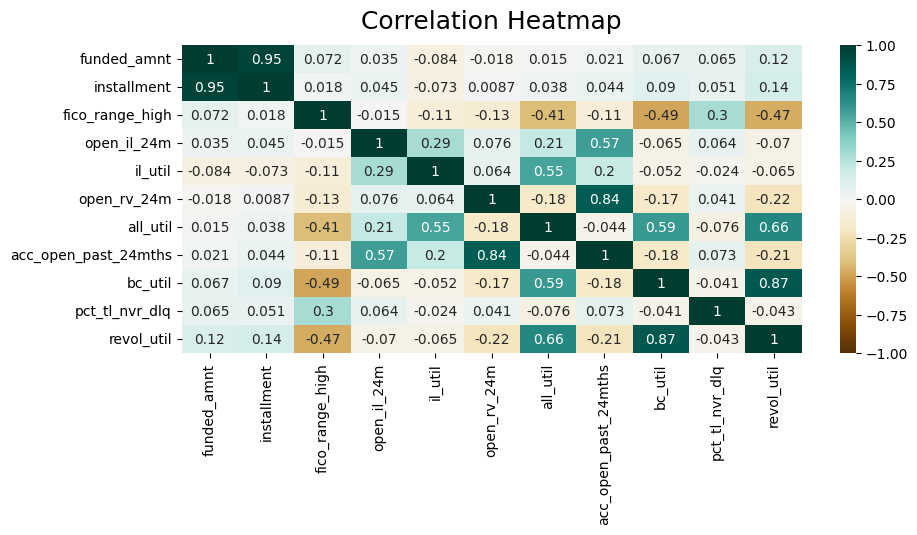

In [830]:
# lets us a correlation matrix to look at the features with VIF rates
# to see wich ones are correlated and should be removed

plt.figure(figsize=(10,4))
heatmap = sns.heatmap(df_total[matrix_lst].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

In [831]:
# we will remove one of the two varaibles highly correlated with eachother
# drop pct_tl_nvr_dlq as well -- high VIF and low correlation to loan_status

df_vif.drop(['acc_open_past_24mths', 'funded_amnt', 'bc_util', 'pct_tl_nvr_dlq', 'revol_util'], axis=1, inplace=True)



In [832]:
# run VIF calcs again
df = calc_vif(df_vif.dropna())

# new list of cont_features
cont_features = df['variables'].to_list()

# view VIF df
df.sort_values(by=['VIF'], ascending=False)

,variables,VIF
4,fico_range_high,25.834080
9,all_util,15.005977
18,total_bc_limit,14.046459
19,int_rate,10.417876
6,total_acc,9.742418
12,bc_open_to_buy,8.542423
15,num_rev_tl_bal_gt_0,6.692625
16,num_tl_op_past_12m,6.408808
20,earliest_cr_line,6.266332
8,open_rv_24m,5.677363


**Distributions**

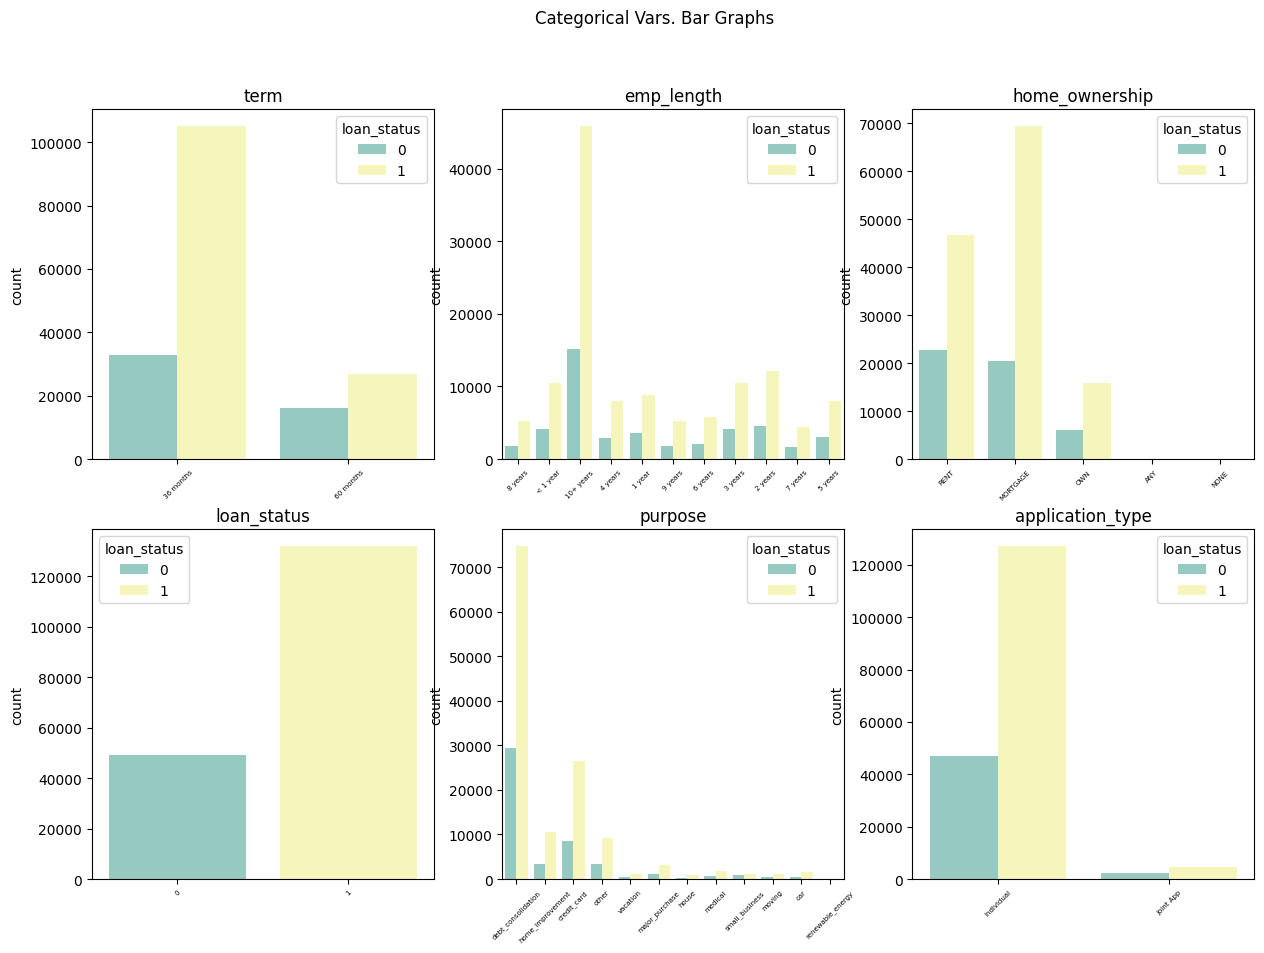

In [833]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize = (15,10))
figure.suptitle('Categorical Vars. Bar Graphs')
axes = axes.flatten()
for ax, catplot in zip(axes,cat_features):
  sns.countplot(x = catplot, data = df_total, ax = ax,hue='loan_status', palette="Set3").set(title =catplot,xlabel='')
  ax.tick_params(axis='x', rotation=45, labelsize=5)



plt.show()

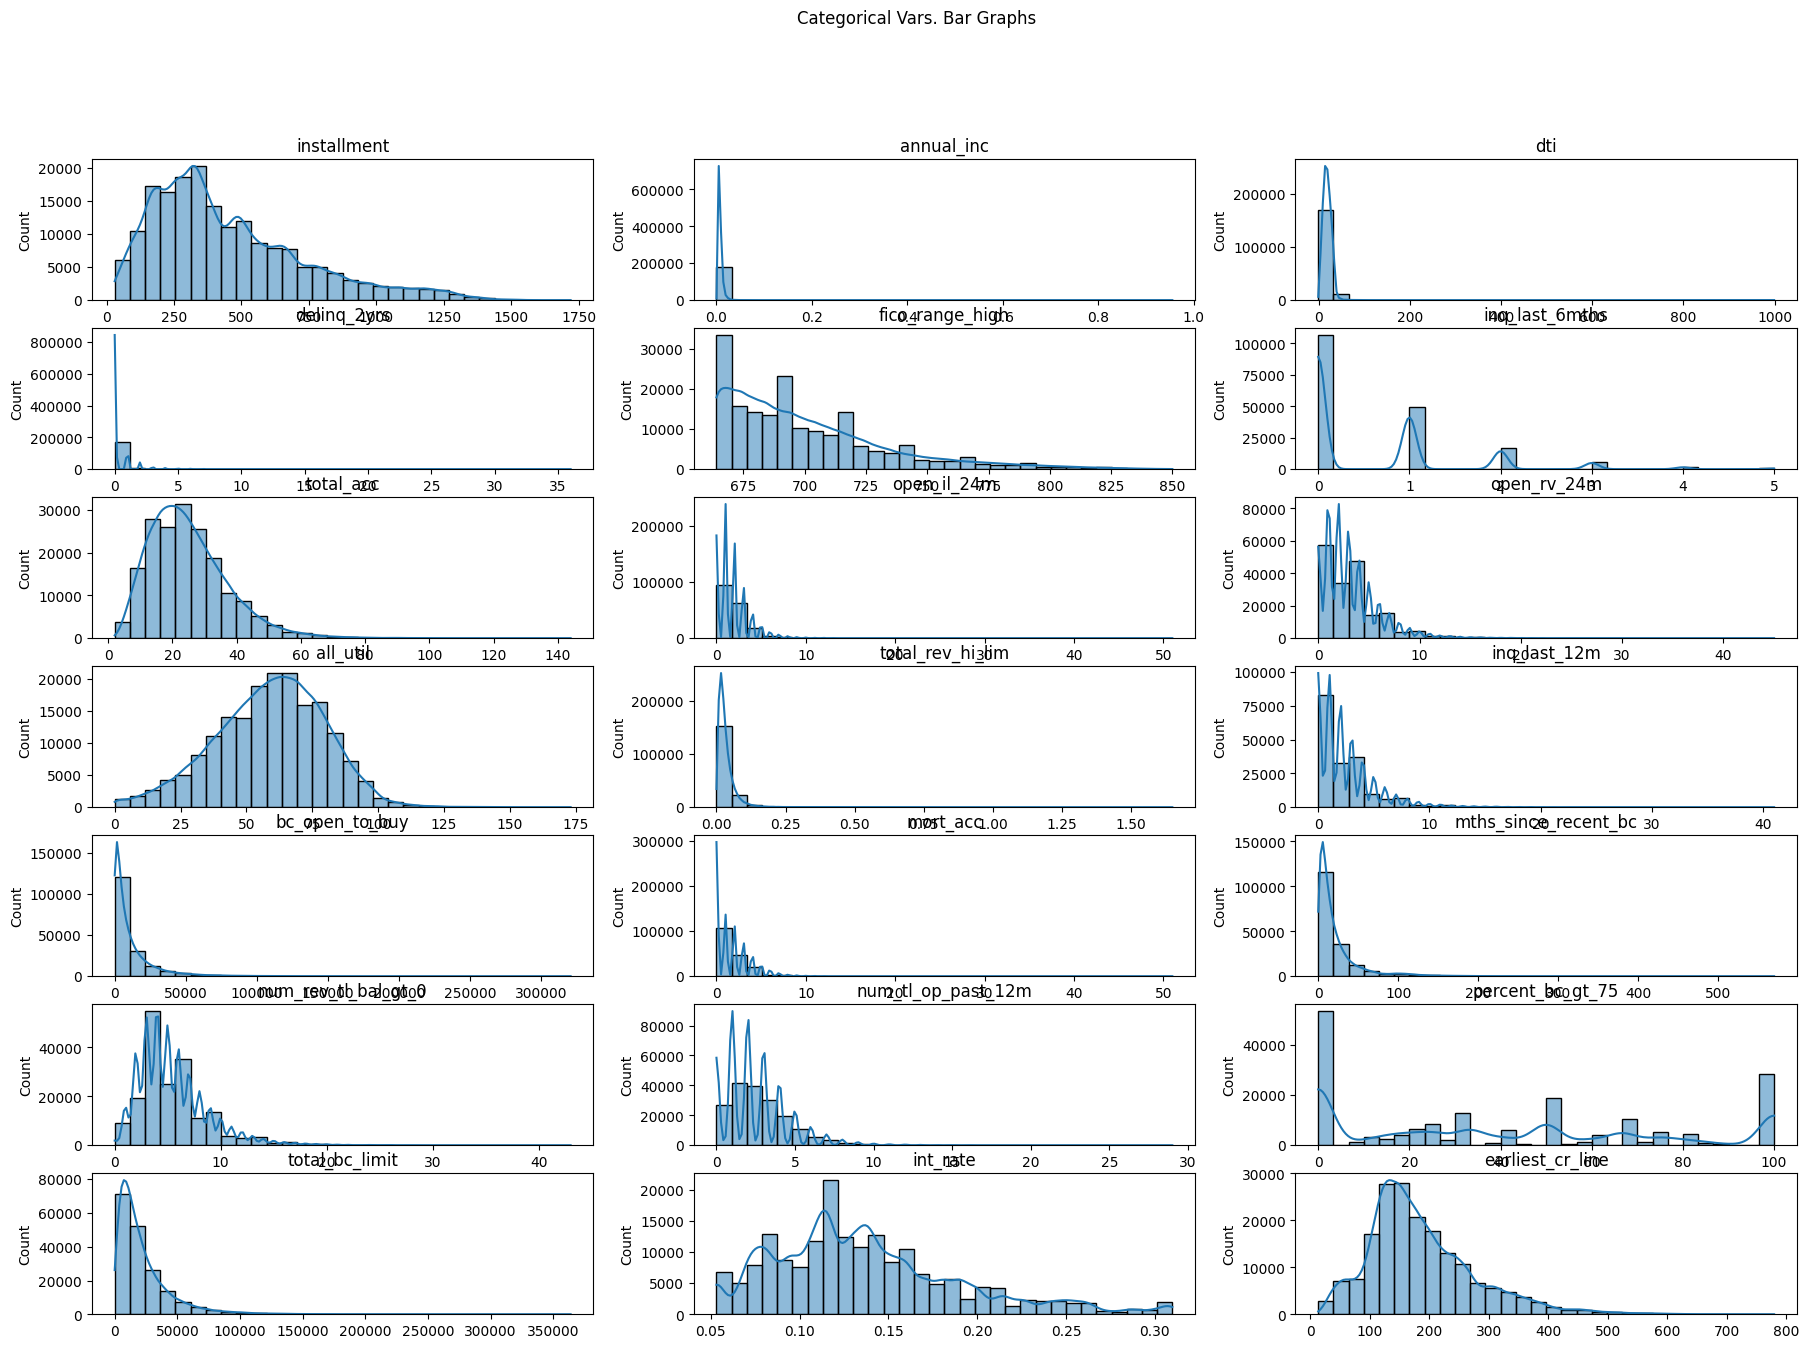

In [834]:
figure, axes = plt.subplots(nrows=7, ncols=3, figsize = (22,15))
figure.suptitle('Categorical Vars. Bar Graphs')
axes = axes.flatten()
for ax, feature in zip(axes,cont_features):
  sns.histplot(data=df_total,ax = ax, x=feature, kde=True, bins = 30).set(title =feature,xlabel='')

plt.show()

In [835]:
df_total[cont_features[0:11]].describe()

,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,total_acc,open_il_24m,open_rv_24m,all_util,total_rev_hi_lim
count,181166.000000,1.811660e+05,181080.000000,181166.000000,181166.000000,181166.000000,181166.000000,181155.000000,181155.000000,181134.000000,1.811660e+05
mean,446.972134,7.900579e+04,18.811623,0.341300,700.378327,0.611682,24.908338,1.790936,3.087974,58.893416,3.387636e+04
std,281.607949,8.205804e+04,13.298276,0.923422,32.735229,0.894877,12.183030,1.706094,2.742283,20.692659,3.423576e+04
min,30.120000,0.000000e+00,-1.000000,0.000000,664.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,240.920000,4.800000e+04,12.030000,0.000000,674.000000,0.000000,16.000000,1.000000,1.000000,45.000000,1.450000e+04
50%,372.710000,6.650000e+04,18.000000,0.000000,694.000000,0.000000,23.000000,1.000000,2.000000,60.000000,2.490000e+04
75%,600.110000,9.500000e+04,24.690000,0.000000,714.000000,1.000000,32.000000,3.000000,4.000000,73.000000,4.200000e+04
max,1719.830000,9.550000e+06,999.000000,36.000000,850.000000,5.000000,144.000000,51.000000,45.000000,173.000000,1.649101e+06


In [836]:
df_total[cont_features[11:]].describe()

,inq_last_12m,bc_open_to_buy,mort_acc,mths_since_recent_bc,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit,int_rate,earliest_cr_line
count,181155.000000,178974.000000,181166.000000,179098.000000,181166.000000,181166.000000,178962.000000,181166.000000,181166.000000,181166.000000
mean,2.385885,11423.195252,1.576543,22.114786,5.440982,2.406633,39.848768,22356.227327,0.137328,185.872520
std,2.578089,16271.454090,1.862339,30.074622,3.272758,2.000949,35.951874,22033.000701,0.053663,90.578864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053200,13.000000
25%,1.000000,1934.000000,0.000000,5.000000,3.000000,1.000000,0.000000,8100.000000,0.099300,126.000000
50%,2.000000,5738.000000,1.000000,12.000000,5.000000,2.000000,33.300000,15800.000000,0.127900,167.000000
75%,3.000000,14224.750000,3.000000,26.000000,7.000000,3.000000,66.700000,29000.000000,0.162900,231.000000
max,41.000000,320558.000000,51.000000,570.000000,43.000000,29.000000,100.000000,363800.000000,0.309900,780.000000


# Modeling

We are only using models that give a probabilistic outcome to help
decide which loans to invest in


*   Logistic Regression
*   Random Forest



In [837]:
# light feature engineering

###### cont. features

# features to impute with median
median_impute = [
    'dti', 'open_il_24m', 'open_rv_24m', 'all_util',
    'inq_last_12m', 'bc_open_to_buy', 'mths_since_recent_bc', 'percent_bc_gt_75'
]

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(df_total.loc[:, median_impute])
x_cont_imputed = imp_median.transform(df_total.loc[:, median_impute].copy())

# standard scale all continoues -- needed for regularization
x_non_imputed_lst = [x for x in cont_features if x not in median_impute]

scaler_imputed = StandardScaler()
x_cont_imputed = scaler_imputed.fit_transform(x_cont_imputed)

scaler_non_imputed = StandardScaler()
x_non_imputed = scaler_non_imputed.fit_transform(df_total.loc[:,x_non_imputed_lst])

####### cat. features

# feature to impute with mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(df_total.loc[:, 'emp_length'].to_numpy().reshape(-1, 1))
x_cat_imputed = imp_mode.transform(df_total.loc[:, 'emp_length'].to_numpy().reshape(-1, 1).copy())

# transform employ_len to ordinal variable
emply_len_dict = {
    '< 1 year': 1,
    '1 year': 2,
    '2 years': 3,
    '3 years': 4,
    '4 years': 5,
    '5 years': 6,
    '6 years': 7,
    '7 years': 8,
    '8 years': 9,
    '9 years': 10,
    '10+ years': 11
}
df = pd.DataFrame(x_cat_imputed, columns =['emp_lenght'])
df.replace(emply_len_dict, inplace=True)

# convert to array
x_cat_imputed = df.to_numpy()

# adjust feature lists
cat_features.remove('loan_status')
x_cat_features = cat_features
x_cat_features.remove('emp_length')

# get dummies for categorical features
df_cat = pd.get_dummies(df_total.loc[:, x_cat_features])
df_cat_feature_lst = df_cat.columns.to_list()

# convert to numpy
df_cat = df_cat.to_numpy()

# combine all X features
X = np.concatenate((x_cont_imputed, x_non_imputed, x_cat_imputed, df_cat),axis=1)

# get all the features in corresponding order within a list
X_feature_list = list(itertools.chain(median_impute,x_non_imputed_lst, ['emp_length'], df_cat_feature_lst))

In [838]:
# create final dfs: modeling & investing

# create df with all X features
df_X = pd.DataFrame(X, columns=X_feature_list)

# reset df_total index
df_total.reset_index(drop=True, inplace=True)

# create final df
final_df = pd.concat([df_X, df_total.loc[:, ['id', 'loan_status']]], axis=1)

# create df with funds for modeling: remove investment funds
modeling_df = final_df[~final_df.id.isin(df_invest.id)]

# create df with funds for investment
invest_df = final_df[final_df.id.isin(df_invest.id)]

In [839]:
# get predictors
X = modeling_df.loc[:, X_feature_list].to_numpy()
X_invest = invest_df.loc[:, X_feature_list].to_numpy()

# get the target feature
y = modeling_df.loc[:, 'loan_status'].to_numpy()

# get train/test splits 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1, stratify=y,
)

In [840]:
# functions

def model_evaluation(model, metrics_list, X, y, fold_splits = 5):
  sk_folds = StratifiedKFold(n_splits = fold_splits)
  scores_list = []
  for m in metrics_list:
    #scores_list = []
    scores = cross_val_score(model, X, y, cv = sk_folds, scoring = m)
    scores_list.append([np.mean(scores), np.median(scores), np.std(scores)])

  pd.DataFrame(scores_list, columns = ['Mean', 'Median', 'Stdev'], index = metrics)

  return pd.DataFrame(scores_list, columns = ['Mean', 'Median', 'Stdev'], index = metrics)

In [841]:
# models
clf_logistic = LogisticRegression(random_state=0, max_iter=500, penalty=None)
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_dt = DecisionTreeClassifier(random_state=42, max_features = 5)

# metrics
metrics = ['accuracy','precision','recall','f1']

for c in [clf_logistic, clf_rf]:
  print('classifer :', str(c))
  print(model_evaluation(c, metrics, X_train, y_train, 5))
  print('')

classifer : LogisticRegression(max_iter=500, penalty=None, random_state=0)
               Mean    Median     Stdev
accuracy   0.738768  0.738505  0.000822
precision  0.754597  0.754675  0.000306
recall     0.950024  0.950475  0.001673
f1         0.841107  0.841034  0.000639

classifer : RandomForestClassifier(max_depth=10)
               Mean    Median     Stdev
accuracy   0.737735  0.737356  0.001210
precision  0.743282  0.743065  0.000622
recall     0.977704  0.977488  0.001095
f1         0.844343  0.844288  0.000605



In [842]:
# models
clf_logistic = LogisticRegression(random_state=0, max_iter=500, penalty='l2')
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10)
clf_dt = DecisionTreeClassifier(random_state=42, max_features = 5)

# metrics
metrics = ['accuracy','precision','recall','f1']

for c in [clf_logistic]:
  print('classifer :', str(c))
  print(model_evaluation(c, metrics, X_train, y_train, 5))
  print('')

classifer : LogisticRegression(max_iter=500, random_state=0)
               Mean    Median     Stdev
accuracy   0.738789  0.738647  0.000819
precision  0.754606  0.754666  0.000286
recall     0.950044  0.950573  0.001659
f1         0.841121  0.841121  0.000638



In [843]:
param_grid = {
              'penalty': [None,'l2']

}

clf_logistic = LogisticRegression(random_state=0, max_iter=500)
grid_search_logistic = GridSearchCV(estimator = clf_logistic,  param_grid = param_grid,cv = 5, scoring=make_scorer(precision_score))
grid_search_logistic.fit(X_train, y_train)

final_model_logistic = grid_search_logistic.best_estimator_
print(final_model_logistic)

LogisticRegression(max_iter=500, random_state=0)


In [844]:
# models give relatively the same results lets do some light parameter tunning

param_grid = {
              'max_depth' : [9,10,11,12]
}

clf_rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid,cv=5, scoring=make_scorer(precision_score))
grid_search_rf.fit(X_train, y_train)

final_model_rf = grid_search_rf.best_estimator_
print(final_model_rf )

RandomForestClassifier(max_depth=12, random_state=42)


In [845]:
def predict_(model_, X_test, y_test, scoring_metrics):
  #model_.fit(X_train, y_train)
  predicted = model_.predict(X_test)

  df = scoring_metrics(y_test, predicted)

  return df

def scoring_metrics(true_values, predicted):

  score_dict = {
      'accuracy': [accuracy_score(true_values, predicted)],
      'precision': [precision_score(true_values, predicted)],
      'recall': [recall_score(true_values, predicted)],
      'f1': [f1_score(true_values, predicted)],
  }

  return pd.DataFrame(score_dict)

In [846]:
predict_(final_model_logistic, X_test, y_test, scoring_metrics)

,accuracy,precision,recall,f1
0,0.736751,0.753246,0.949262,0.83997


In [847]:
predict_(final_model_rf, X_test, y_test, scoring_metrics)

,accuracy,precision,recall,f1
0,0.738517,0.745765,0.972125,0.844032


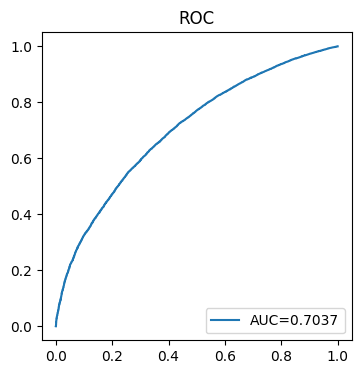

In [848]:
# ROC/AUC

# get data
y_pred_proba = final_model_logistic.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = round(roc_auc_score(y_test, y_pred_proba),4)

#create ROC curve
plt.subplots( figsize=(4,4))
plt.title('ROC')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

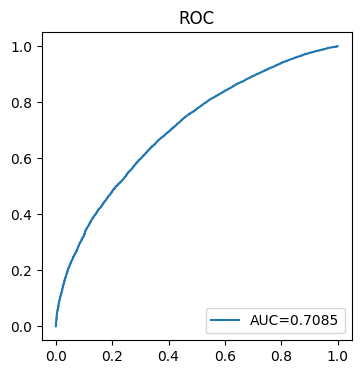

In [849]:
# ROC/AUC

# get data
y_pred_proba_rf = final_model_rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_rf)
auc = round(roc_auc_score(y_test, y_pred_proba_rf),4)

#create ROC curve
plt.subplots( figsize=(4,4))
plt.title('ROC')
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

**Evaluate loans for investment**

Both models are very comparable but since the logistic performed a tad better on precision, we will use this model for selecting a loan to invest in.

Give investment recommendations really depends on the risk tolerance of an investor.  More risky funds have probability of being not paid back but yield more in interest payments - i.e. higher higher, return.

In [850]:
# get prediction probabilites of loans being paif off
y_pred_proba = final_model_logistic.predict_proba(X_invest)[::,1]

# inverse transform interest rates
df = scaler_non_imputed.inverse_transform(invest_df.loc[:, x_non_imputed_lst])
df=pd.DataFrame(df, columns=x_non_imputed_lst)
# add pred_prob to the df
df['pay_off_prob'] = y_pred_proba


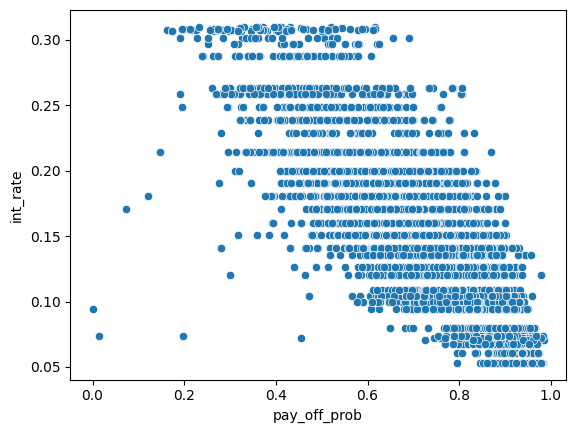

In [851]:
sns.scatterplot(x="pay_off_prob",y="int_rate", data=df)
plt.show()
# we can see that the is an inverse relationship between prediction probabliity
# of a loan being paid vs interest -- which was expcted.

In [852]:
# since we only have $100s to spend and taking the approach to not lose money,
# the best investment is fund 121412315. It has on of the highest prediction
# probabilites  to paid off and has a significantly high interest at 12% compared
# to loans with equalivant prediction probabilites

df[df.pay_off_prob >= .95].sort_values(['pay_off_prob', 'int_rate'], ascending=[False, False])[['int_rate',"pay_off_prob"]].head(25)


,int_rate,pay_off_prob
825,0.0707,0.984305
3724,0.0532,0.982705
2471,0.0735,0.982209
3472,0.0532,0.981098
5170,0.0532,0.980890
4332,0.0532,0.979770
11,0.1199,0.979019
1544,0.0532,0.978883
3861,0.0532,0.978434
5024,0.0721,0.977964


In [853]:
invest_df.iloc[11,:]['id']

121412315.0